In [1]:
import numpy as np 
import pandas as pd 
 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold 
from sklearn.metrics import  confusion_matrix, f1_score, make_scorer, recall_score
from sklearn.preprocessing import StandardScaler  
from sklearn.neighbors import KNeighborsClassifier 

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE 
import matplotlib.pyplot as plt 

df = pd.read_csv('journeys.csv') 
targets = df['Conversion'] 
df.drop(['Journey Start Date', 'Journey End Date', 'Events Combo', 'User-Journey'], axis=1, inplace=True) 
df = pd.get_dummies(df) 
 
X_train, X_test, y_train, y_test = train_test_split(df, targets, stratify=targets) 
X_train.drop(['Conversion'], axis=1, inplace=True) 
X_test.drop(['Conversion'], axis=1, inplace=True) 

#scaler = StandardScaler() 
#scaler.fit(X_train) 
 
#X_train = scaler.transform(X_train) 
#X_test = scaler.transform(X_test) b

In [2]:
param_grid = { 
    'min_samples_split': [3, 5, 10],  
    'n_estimators' : [300], 
    'max_depth': [3, 5, 15, 25], 
    'max_features': [3, 5, 10, 19]

} 
  
def grid_search_wrapper(_model = '', refit_score='fb_score', param_grid=param_grid): 
    """ 
    fits a GridSearchCV classifier using refit_score for optimization 
    prints classifier performance metrics 
    """ 
    skf = StratifiedKFold(n_splits=10) 
    grid_search = GridSearchCV(_model, param_grid, scoring=make_scorer(f1_score), refit=refit_score, 
                           cv=skf, return_train_score=True, n_jobs=-1, error_score='raise') 
    grid_search.fit(X_train.values, y_train.values) 
 
    # make the predictions 
    y_pred = grid_search.predict(X_test.values) 
 
    print('Best params for {}'.format(refit_score)) 
    print(grid_search.best_params_) 
 
    # confusion matrix on the test data. 
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score)) 
    print(pd.DataFrame(confusion_matrix(y_test, y_pred), 
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])) 
    return grid_search

def show_model_output(grid_search_output, num_to_show = 10): 
    df1 = pd.DataFrame(grid_search_output.cv_results_['params'])
    df2 = pd.DataFrame(grid_search_output.cv_results_['mean_train_score']).rename(columns={0: "mean_train_score"})
    df3 = pd.DataFrame(grid_search_output.cv_results_['mean_test_score']).rename(columns={0: "mean_test_score"})
    result = pd.concat([df2,df3,df1], axis = 1).sort_values(by='mean_test_score', ascending=False)
    result = result.head(num_to_show)
    return result



### Random Forest

In [3]:
clf = RandomForestClassifier(n_jobs=-1)
grid_search_clf = grid_search_wrapper(_model = clf, refit_score='fb_score', param_grid=param_grid) 
#y_scores = grid_search_clf.predict_proba(X_test)[:, 1]  

Best params for fb_score
{'max_depth': 15, 'max_features': 10, 'min_samples_split': 10, 'n_estimators': 300}

Confusion matrix of Random Forest optimized for fb_score on the test data:
     pred_neg  pred_pos
neg      1600         5
pos       122       138


In [4]:
show_model_output(grid_search_output= grid_search_clf, num_to_show=10)

,mean_train_score,mean_test_score,max_depth,max_features,min_samples_split,n_estimators
32,0.731109,0.703536,15,10,10,300
44,0.730494,0.700766,25,10,10,300
22,0.705631,0.700649,5,19,5,300
41,0.729981,0.700443,25,5,10,300
23,0.706653,0.700094,5,19,10,300
29,0.727865,0.699947,15,5,10,300
35,0.734256,0.699697,15,19,10,300
47,0.735766,0.699636,25,19,10,300
21,0.706821,0.699548,5,19,3,300
26,0.728323,0.696563,15,3,10,300


### Logistic Regression

In [5]:
param_grid = {
     'penalty': ['l1', 'l2', 'elasticnet'],
     'l1_ratio': [0, .25, .5, .75, 1]

}

In [6]:
logreg = LogisticRegression(random_state=0, solver='saga')
grid_search_lr = grid_search_wrapper(_model = logreg, refit_score='fb_score', param_grid=param_grid) 

Best params for fb_score
{'l1_ratio': 0, 'penalty': 'l1'}

Confusion matrix of Random Forest optimized for fb_score on the test data:
     pred_neg  pred_pos
neg      1598         7
pos       179        81


C:\Users\Mark\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\Mark\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [7]:
show_model_output(grid_search_output= grid_search_lr, num_to_show=10)

,mean_train_score,mean_test_score,l1_ratio,penalty
0,0.472181,0.463942,0.00,l1
3,0.472181,0.463942,0.25,l1
6,0.472181,0.463942,0.50,l1
9,0.472181,0.463942,0.75,l1
12,0.472181,0.463942,1.00,l1
14,0.472181,0.463942,1.00,elasticnet
8,0.469400,0.461217,0.50,elasticnet
11,0.469446,0.461217,0.75,elasticnet
5,0.468874,0.459520,0.25,elasticnet
1,0.464814,0.456422,0.00,l2


### XGBoost

In [8]:
# https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost/notebook
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [9]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [10]:
grid_search_xgb = grid_search_wrapper(_model = xgb, refit_score='fb_score', param_grid=param_grid) 

C:\Users\Mark\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:42:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "l1_ratio", "penalty", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:42:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params for fb_score
{'l1_ratio': 0, 'penalty': 'l1'}

Confusion matrix of Random Forest optimized for fb_score on the test data:
     pred_neg  pred_pos
neg      1600         5
pos       118       142


In [11]:
show_model_output(grid_search_output= grid_search_xgb, num_to_show=10)

,mean_train_score,mean_test_score,l1_ratio,penalty
0,0.727187,0.705491,0.00,l1
1,0.727187,0.705491,0.00,l2
2,0.727187,0.705491,0.00,elasticnet
3,0.727187,0.705491,0.25,l1
4,0.727187,0.705491,0.25,l2
5,0.727187,0.705491,0.25,elasticnet
6,0.727187,0.705491,0.50,l1
7,0.727187,0.705491,0.50,l2
8,0.727187,0.705491,0.50,elasticnet
9,0.727187,0.705491,0.75,l1


### SHAP

##### Calculate RF Shap

In [12]:
import shap
model = grid_search_clf.best_estimator_.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

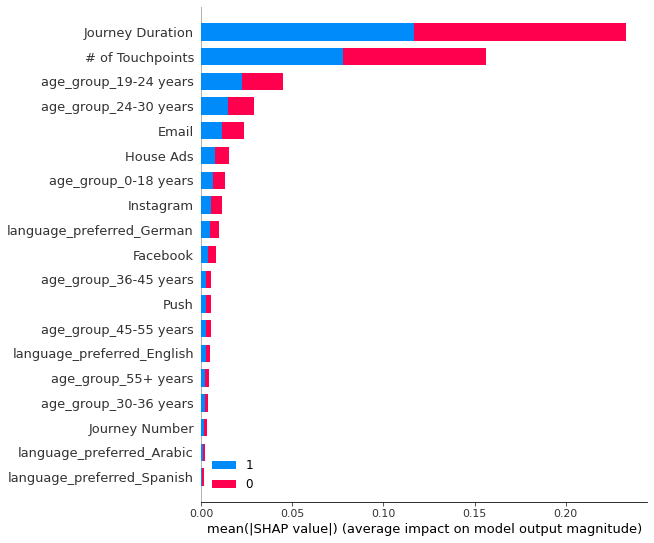

In [13]:
shap.summary_plot(shap_values, X_train, class_names=model.classes_)

##### Logistic Regression

In [15]:
## This isnt working

In [14]:
import shap
model = grid_search_lr.best_estimator_.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


Exception: Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._logistic.LogisticRegression'>